# Load libraries

In [1]:
import pandas as pd
import numpy as np

from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style('darkgrid')

# Load dataset

This is a huge dataset, so to avoid running out of memory, we could only load the dataset partially

In [2]:
# Skip date information
df1 = pd.read_csv('/home/eduardo/projects/recommender-data/combined_data_1.txt',
                 header=None, names=['Cust_Id', 'Rating'], usecols=[0,1])

In [3]:
# First row is the movie ID, following rows have customer id and rating given to movie 1
df1.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [4]:
df1.dtypes

Cust_Id     object
Rating     float64
dtype: object

In [5]:
df1.shape

(24058263, 2)

In [6]:
# NaN ratings correspond to row with a new movie ID (e.g. 1:)
df1.isna().sum()

Cust_Id       0
Rating     4499
dtype: int64

In [7]:
# Load remaining datasets
df2 = pd.read_csv('/home/eduardo/projects/recommender-data/combined_data_2.txt',
                 header=None, names=['Cust_Id', 'Rating'], usecols=[0,1])
#df3 = pd.read_csv('/home/eduardo/projects/recommender-data/combined_data_3.txt',
#                 header=None, names=['Cust_Id', 'Rating'], usecols=[0,1])
#df4 = pd.read_csv('/home/eduardo/projects/recommender-data/combined_data_4.txt',
#                 header=None, names=['Cust_Id', 'Rating'], usecols=[0,1])

print(df2.shape)
#print(df3.shape)
#print(df4.shape)

(26982302, 2)


In [8]:
# Merge the datasets
df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

/tmp/ipykernel_13561/209923039.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2)


In [9]:
# Reset index and show shape
df.index = np.arange(0, len(df))
print(df.shape)
df.tail()

(51040565, 2)


,Cust_Id,Rating
51040560,2420260,1.0
51040561,761176,3.0
51040562,459277,3.0
51040563,2407365,4.0
51040564,627867,3.0


In [10]:
df.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [11]:
# Remove the other dfs from memory
del df1, df2#, df3, df4

# Data visualization

In [12]:
# Look at the Rating distribution
rating_dist = df.groupby('Rating')['Rating'].agg(['count'])
rating_dist.head()

,count
Rating,
1.0,2376944
2.0,5208010
3.0,14730279
4.0,17149528
5.0,11566594


In [13]:
# Movie count - we know rows with movie ID have NaN rating
movie_count = df['Rating'].isnull().sum()

In [14]:
# Customer count - need to take rows that have movie IDs into account
cust_count = df['Cust_Id'].nunique() - df['Rating'].isnull().sum()

In [15]:
# Total Rating count - again, take rows with movie IDs into account
rating_count = df['Cust_Id'].count() - df['Rating'].isnull().sum()

In [16]:
#rating_dist.iloc[0][0]/4

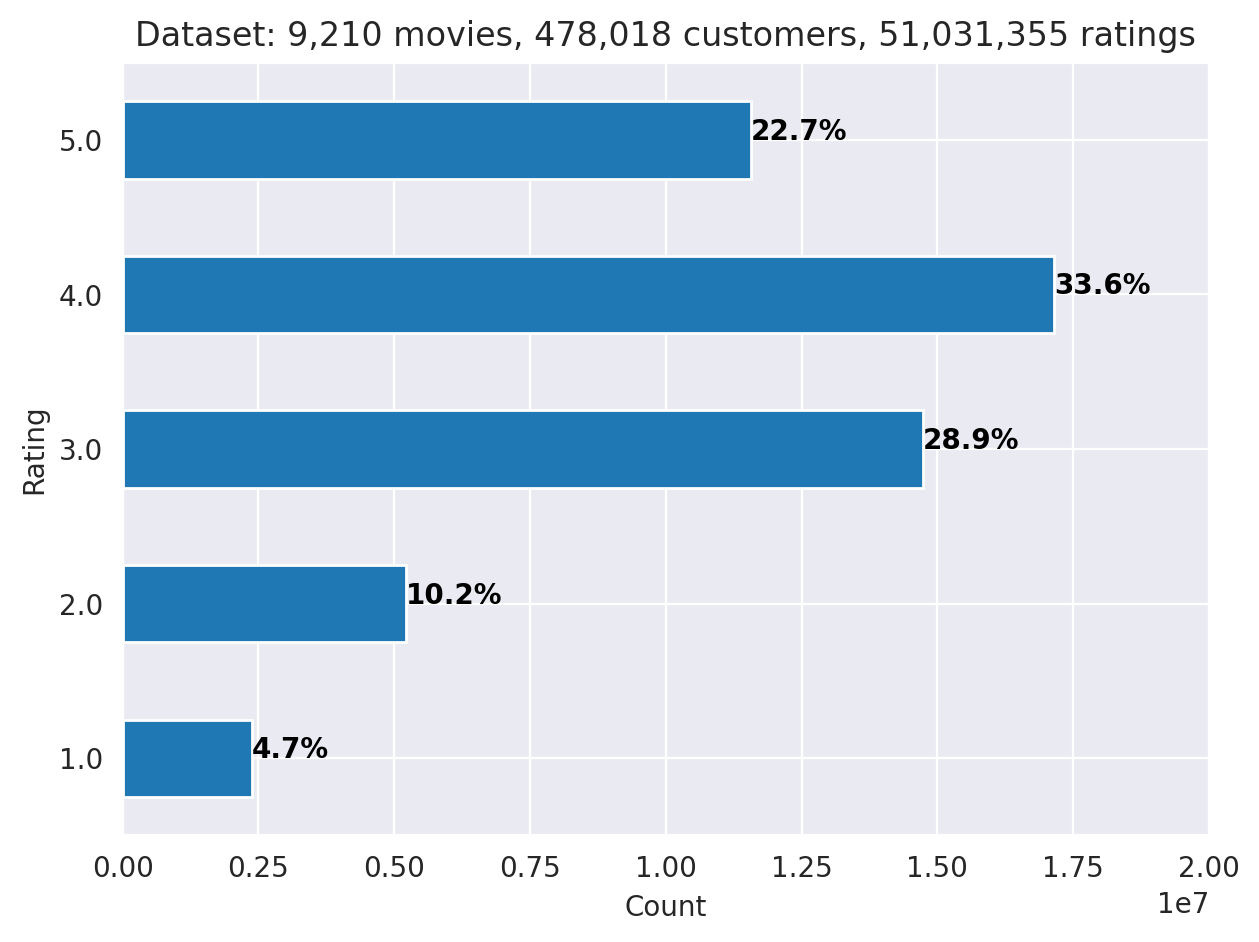

In [65]:
# Create graph object
ax = rating_dist.plot(kind='barh', legend=False)

# Add features
plt.title('Dataset: {:,} movies, {:,} customers, {:,} ratings'.format(movie_count, cust_count, rating_count))
plt.xlim(right=2e7)
plt.xlabel('Count')

# Add percentages to each bar
for i in range (1, 6):
    ax.text(x=rating_dist.iloc[i-1], 
            y=i-1, 
            s='{:.1f}%'.format(rating_dist.iloc[i-1][0]*100 / rating_dist.sum()[0]),
            color='black', 
            weight='bold')

plt.tight_layout()
#plt.savefig('../saves/images/rating_distrib.png')
plt.show()

In [19]:
# Not a normal distribution, we can see there are more ratings over 3.0

# Data cleaning

Let's create a new column using the Movie IDs. These are currently showing as a Cust_Id with missing rating, so we can easily select these rows using pandas filters.

In [19]:
# Create Movie_Id column using the value under Cust_Id with empty Rating
df['Movie_Id'] = df[df['Rating'].isna()]['Cust_Id'].str.replace(':', '')
df.head()

,Cust_Id,Rating,Movie_Id
0,1:,NaN,1
1,1488844,3.0,NaN
2,822109,5.0,NaN
3,885013,4.0,NaN
4,30878,4.0,NaN


In [20]:
# Fill all NaN Movie_Id using ffill - propagate last valid obsv
df['Movie_Id'].fillna(method='ffill', inplace=True)
df.head()

,Cust_Id,Rating,Movie_Id
0,1:,NaN,1
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1


In [21]:
# Drop rows with missing ratings - these correspond to Movie_Id and we have this as a new feat
df.dropna(subset='Rating', inplace=True)

In [22]:
# Check the results
print(df.head())

   Cust_Id  Rating Movie_Id
1  1488844     3.0        1
2   822109     5.0        1
3   885013     4.0        1
4    30878     4.0        1
5   823519     3.0        1


# Data Slicing

To make the dataset more manageable and also improve the quality of the recommendations, we can filter out some entries:
- Remove movies with very few reviews (since they are not popular, the rating may be less reliable)

- Remove customers with very few reviews (since there are not many reviews, it may be hard to match them with other customers as well)

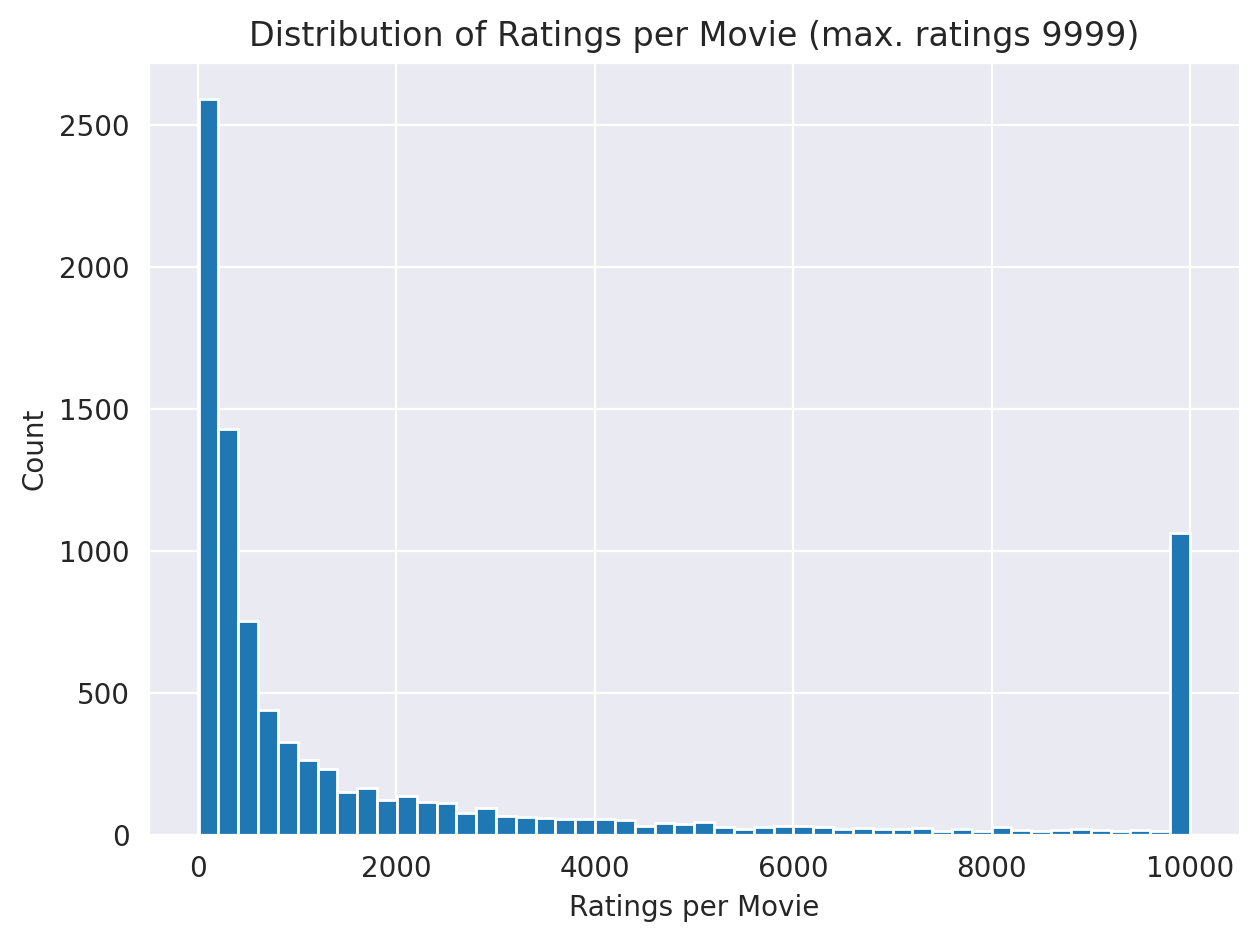

In [61]:
# Get data on number of movie ratings
data = df.groupby('Movie_Id')['Rating'].count().clip(upper=9999)

# Create a histogram to have an idea of ratings per movie
ax = data.hist(bins=50) 

ax.set_title('Distribution of Ratings per Movie (max. ratings 9999)')
ax.set_ylabel('Count')
ax.set_xlabel('Ratings per Movie')
plt.tight_layout()
#plt.savefig('../saves/images/rating_permovie_distrib.png')
plt.show()

In [62]:
len(data)

9210

In [63]:
del data

In [26]:
# Filter out movies with few ratings
# Min number of ratings per movie
min_mov_ratings = 10000

# create mask with movies that have more than min_mov_ratings
filter_movies = (df['Movie_Id'].value_counts() > min_mov_ratings)

# save index of movies with more than min_mov_ratings to a list
filter_movies = filter_movies[filter_movies].index.tolist()
len(filter_movies)

1053

We have reduced the number of unique movies from 9210 to 1053

In [27]:
cust_data = df.groupby('Cust_Id').count()

In [28]:
len(cust_data)

478018

In [29]:
del cust_data

In [30]:
# Filter out customers with few ratings
# Min number of ratings per customer
min_cust_ratings = 200

# Create user mask
filter_cust = (df['Cust_Id'].value_counts() > min_cust_ratings)

# Set index to a list
filter_cust = filter_cust[filter_cust].index.tolist()

In [31]:
len(filter_cust)

75939

We have reduced the number of unique users from 478018 to 75939

In [32]:
# Now combine both filters to yield a filtered dataset
df_filtered = df[(df['Movie_Id'].isin(filter_movies)) & (df['Cust_Id'].isin(filter_cust))]

In [33]:
# Remove filters from memory 
del filter_movies, filter_cust, min_mov_ratings, min_cust_ratings

In [34]:
# Compare the shapes of raw and filtered dfs
print('Shape of raw user ratings dataframe: {}'.format(df.shape))
print('Shape of filtered user ratings dataframe: {}'.format(df_filtered.shape))

Shape of raw user ratings dataframe: (51031355, 3)
Shape of filtered user ratings dataframe: (21830456, 3)


In [35]:
df_filtered.head()

,Cust_Id,Rating,Movie_Id
5109,785314,1.0,8
5110,243963,3.0,8
5112,1447783,4.0,8
5116,1912665,1.0,8
5119,1744889,1.0,8


# Data Mapping

In [76]:
# Let's load movie title information so we know what movie we are referring to
titles = pd.read_csv('/home/eduardo/projects/recommender-data/movie_titles.csv', 
    header=None, 
    encoding="ISO-8859-1",
    usecols=[0, 1, 2],
    names=['Movie_Id', 'Year', 'Name'])

titles.head()

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [77]:
# Index is redundant with Movie_Id
titles.set_index('Movie_Id', inplace=True)
titles.sample(5)

,Year,Name
Movie_Id,,
559,1940.0,Rebecca: Bonus Material
11126,2000.0,Oz: Season 4
5271,1993.0,Cyborg 2
5257,2003.0,The Secret Lives of Dentists
9282,2005.0,WWE: The Best of Intercontinental Championship...


# Recommenders

## Surprise

In [40]:
# Load the dataset from our filtered Pandas dataframe
reader = Reader(rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(df_filtered[['Cust_Id', 'Movie_Id', 'Rating']], reader)


### Using `train_test_split` and `test()` method

In [43]:
# Split train and test datasets with a 80:20 ratio
train, test = train_test_split(data, test_size=0.2)

# Instantiate the model using SVD algorithm
model = SVD()
model.fit(train)

# Making predictions for first 5 users in test set
pred = model.test(test[:5])
pred

[Prediction(uid='740199', iid='5243', r_ui=3.0, est=2.8422426741198397, details={'was_impossible': False}),
 Prediction(uid='880685', iid='2395', r_ui=4.0, est=3.615878797674962, details={'was_impossible': False}),
 Prediction(uid='2354382', iid='5591', r_ui=3.0, est=3.952796551131126, details={'was_impossible': False}),
 Prediction(uid='1709432', iid='6833', r_ui=3.0, est=3.0785484948319835, details={'was_impossible': False}),
 Prediction(uid='2051003', iid='2452', r_ui=3.0, est=3.85793998004736, details={'was_impossible': False})]

In the output above, each prediction gives an estimated rating (`est`) that a user (`uid`) would give to a movie (`iid`). We can compare this with the actual rating (`r_ui`) given by the user.

### Using cross-validation

In [46]:
# Use cross-validation to evaluate the model
results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.7949  0.7944  0.7946  0.7945  0.7946  0.7937  0.7943  0.7948  0.7952  0.7939  0.7945  0.0004  
MAE (testset)     0.6183  0.6179  0.6181  0.6182  0.6180  0.6174  0.6181  0.6181  0.6186  0.6179  0.6181  0.0003  
Fit time          238.83  244.34  235.15  234.19  229.71  231.41  232.23  232.92  232.88  235.05  234.67  3.99    
Test time         51.90   37.29   31.35   41.70   41.90   36.58   36.78   42.36   37.34   42.64   39.98   5.21    
